# Figure 5 Code

This notebook generates all the data presented in Figure 5 except the MCMC analysis of higher-order triangles. The required input data is the file of single-cells with their type and CN annotations from the CRC dataset.

Some notes:
- In the original paper, there was a CN named dirt corresponding to imaging artefacts that was removed from the analysis.
- CN1 in the paper (T cell enriched) corresponds to 0 (since python is 0 indexed).

In [1]:
import sys
sys.path.append('/media/raid/graham/compute/compute/CellHier/graham/cellhier/')
from cellhier.general import *
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
%matplotlib inline
%pylab inline
from matplotlib import pyplot as plt
import skimage
import pickle
import seaborn as sns
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import connected_components
import itertools
from skimage.color import label2rgb
from scipy import ndimage as ndi
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import connected_components as cc
from multiprocessing import Pool
import copy
from tqdm.notebook import tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
#get windows for CRC dataset
cells2 = pd.read_csv('mendeley_data.csv')
'''
mendeley data.csv is CRC_clusters_neighborhoods_markers.csv
available from the  https://data.mendeley.com/datasets/mpjzbtfgfr/1 
(as listed in Schuerch et al. Cell 2020)
'''

In [5]:
# need this to deal with CN1 called dirt in original dataset
cn_names = {i:i if i!=0 else i+1 for i in range(10)}

In [6]:
pat_gp = cells2[['patients','groups']].drop_duplicates()
pat_to_gp= {a:b for a,b in pat_gp.values}
spot_to_patient = {a:b for a,b in cells2[['spots','patients']].drop_duplicates().values}
spot_group_assignment = {spot: pat_to_gp[spot_to_patient[spot]] for spot in spot_to_patient.keys()}

## Segment the instances and build the tissue graphs for each spot

In [7]:
def segment_instances(spot_id, num_neighbors,min_instance_size,return_kgr = False):
    '''
    This takes a given TMA spot and segments it using connected components of
    k-neighbors graph computed with num_neighbors; 
    only the cells residing in instances with size greater than min_instance_size are returned
    '''
    
    spot = cells2[cells2['spots']==spot_id]
    nn = NearestNeighbors(n_neighbors=10).fit(spot[['X:X','Y:Y']])
    kgr = nn.kneighbors_graph()


    spot_cn_cell_idxs = {}
    spot_inst_assignments = {}
    instance_assignments = {}
    good_instances = {}

    for cn in range(10):        
        idx = np.where(spot['neighborhood10']==cn)[0]
        spot_cn_cell_idxs[cn] = idx
        instance_assignments[cn] = cc(kgr[idx,:][:,idx])[1]
        counts = np.unique(instance_assignments[cn],return_counts=True)
        good_instances[cn] = counts[0][counts[1]>min_instance_size]
        cn_good_inst_idx = np.where(np.isin(instance_assignments[cn],good_instances[cn]))[0]
        good_inst_assignments = instance_assignments[cn][cn_good_inst_idx]
        spot_good_inst_cell_idx = spot_cn_cell_idxs[cn][cn_good_inst_idx]
        
        # this is the pair of index (in the spot) of good cells, as well as their assignments
        spot_inst_assignments[cn] = (spot_good_inst_cell_idx,good_inst_assignments)
    
    if return_kgr:
        return spot, spot_cn_cell_idxs, spot_inst_assignments, kgr
    
    return spot, spot_cn_cell_idxs, spot_inst_assignments

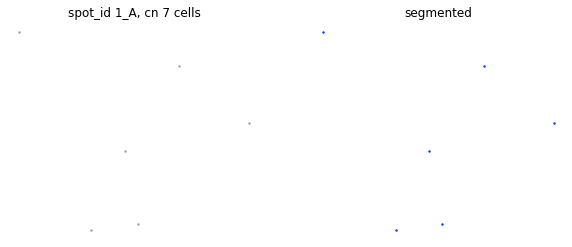

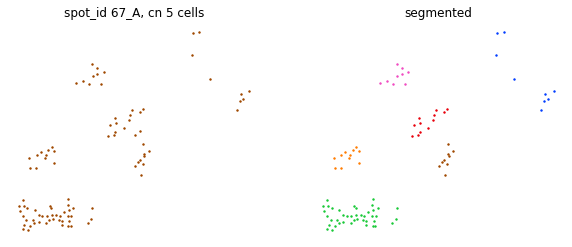

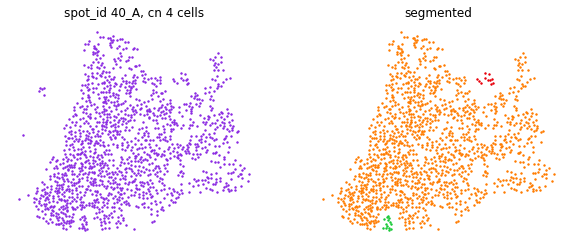

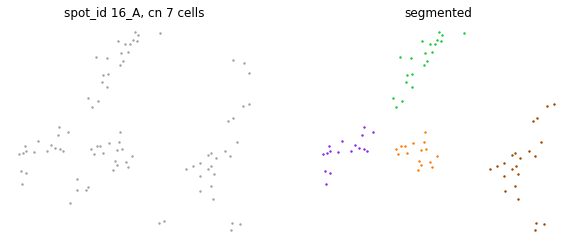

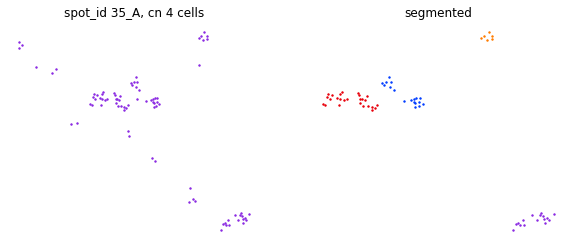

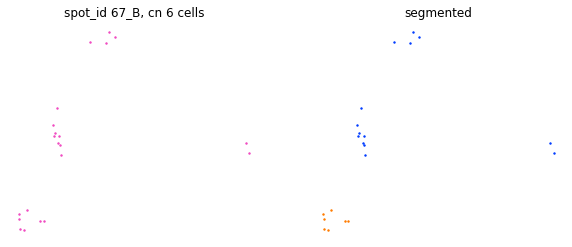

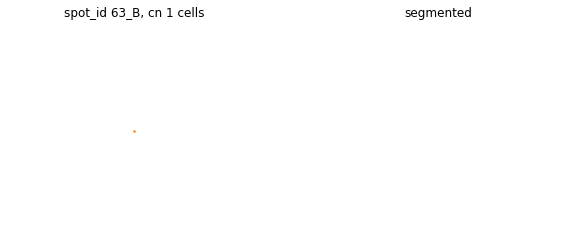

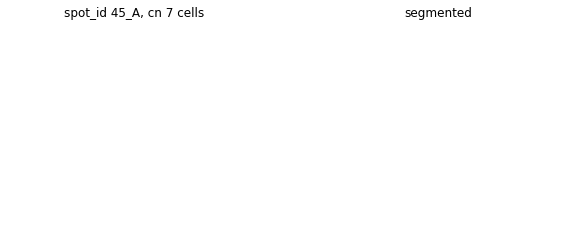

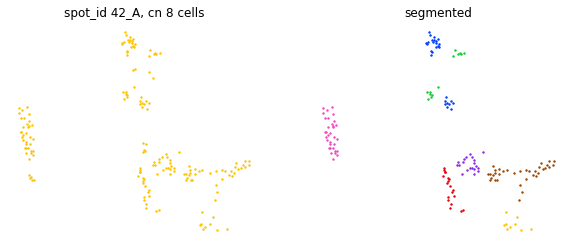

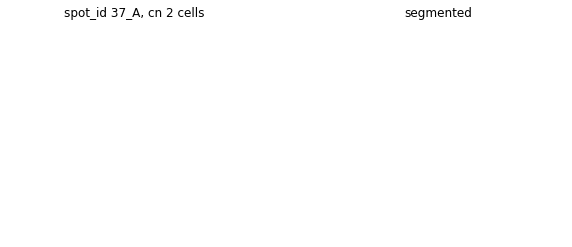

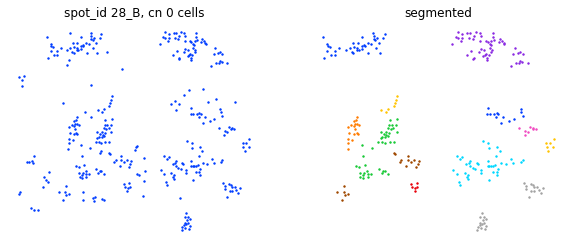

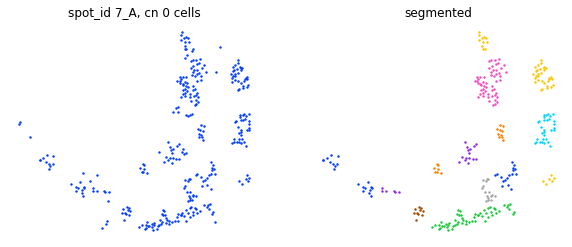

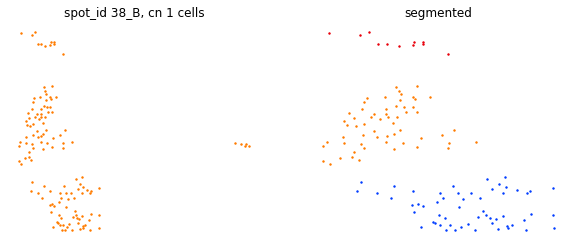

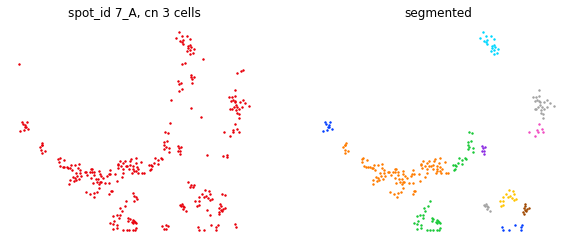

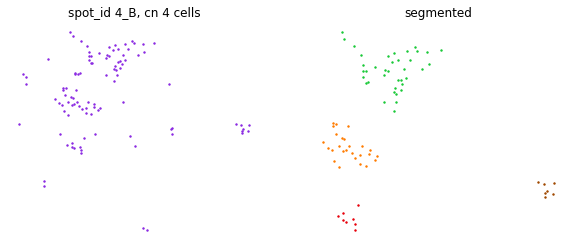

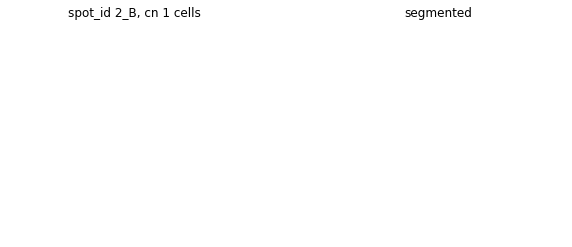

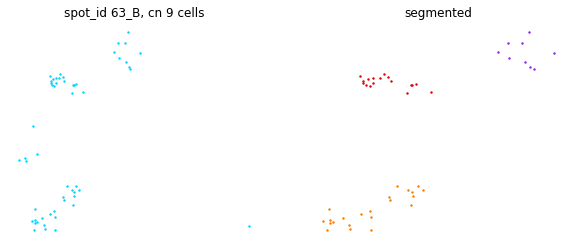

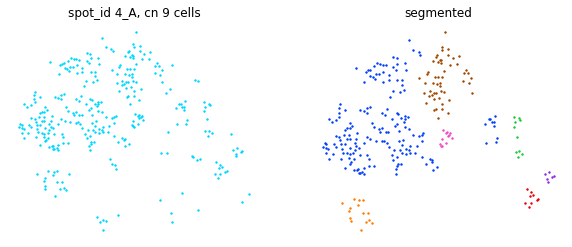

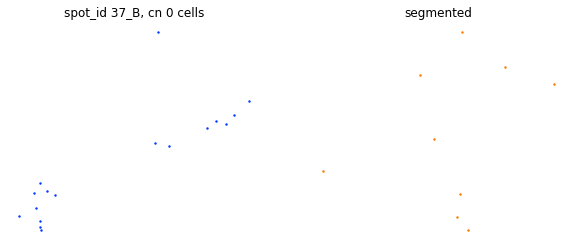

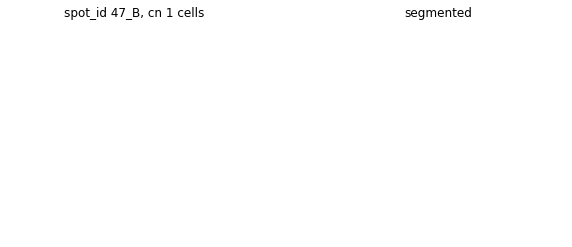

In [8]:
#check that our segmentation is working as we expect for a few randomly selected spot,cn pairs

#plotting params
pal = sns.color_palette('bright',10)
figsize(10,4)

#generate random samples
spot_ids  = cells2['spots'].unique()
spot_cn_combs = list(itertools.product(spot_ids,range(10)))
np.random.seed(10)
np.random.shuffle(spot_cn_combs)

#set params
num_neighbors = 10
min_instance_size = 5

for k in spot_cn_combs[:20]:
    (spot_id, cn) = k
    # use the segment instances script
    spot, spot_cn_cell_idxs, spot_inst_assignments = segment_instances(spot_id,num_neighbors=num_neighbors,min_instance_size=min_instance_size)
    
    
    #plot spot cells of that CN
    plt.subplot(1,2,1)
    sub_spot = spot.iloc[spot_cn_cell_idxs[cn]]
    plt.scatter(sub_spot['X:X'],sub_spot['Y:Y'],c = [pal[cn]],s = 2)
    
    
    plt.title('spot_id {}, cn {} cells'.format(spot_id,cn))
    plt.axis('off')
    
    #plot segmentation colored by instance
    plt.subplot(1,2,2)
    cell_idx,assignment = spot_inst_assignments[cn] 
    for j in unique(assignment):
        
        sub_spot = spot.iloc[cell_idx[assignment ==j]]
        plt.scatter(sub_spot['X:X'],sub_spot['Y:Y'],c = [pal[j%10]],s = 2)
    plt.axis('off')
    plt.title('segmented')
    plt.show()
    

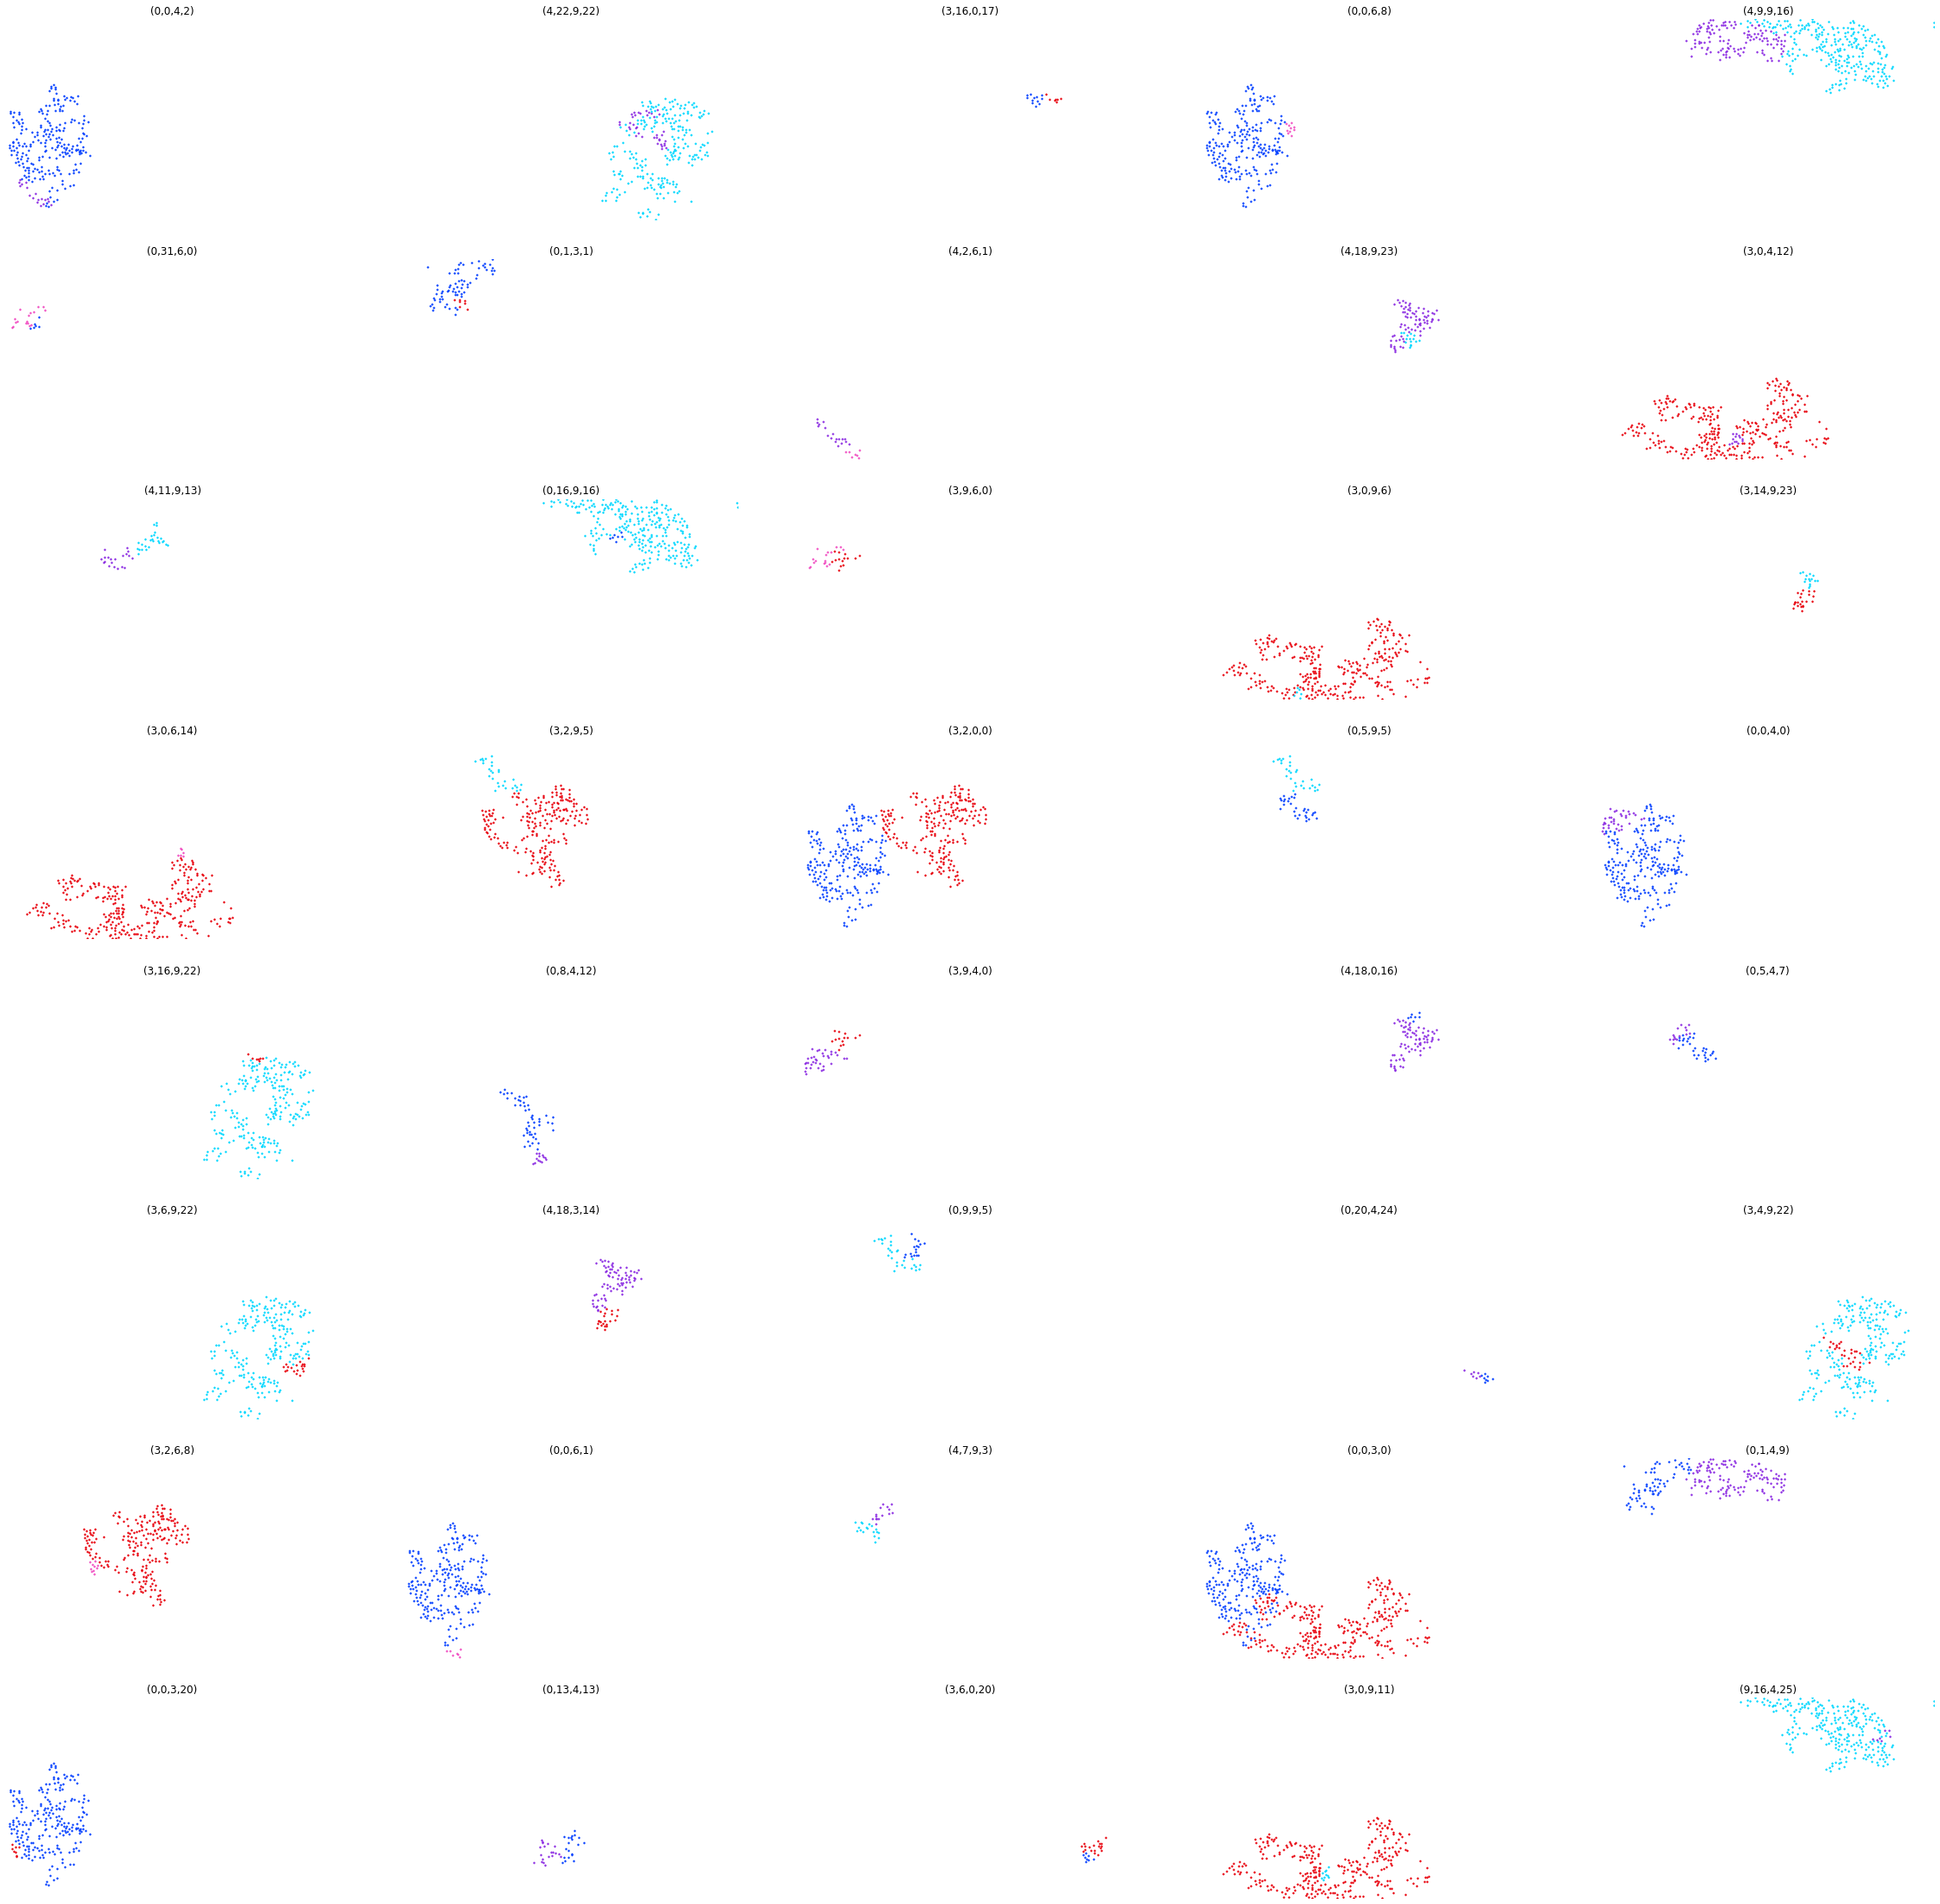

In [9]:
#validate adj graph construction

num_neighbors = 10
min_instance_size = 5

spot_id = '59_A'

spot_data = {}

spot, spot_cn_cell_idxs, inst_assignments,kgr  = segment_instances(spot_id,num_neighbors=num_neighbors,min_instance_size=min_instance_size,return_kgr = True)

spot_adj_graph = nx.Graph()

for cn1 in range(10):
    for cn2 in range(cn1):
        e1,e2 = kgr[inst_assignments[cn1][0],:][:,inst_assignments[cn2][0]].nonzero()
        for s,t in set(list(zip(inst_assignments[cn1][1][e1],inst_assignments[cn2][1][e2]))):
            spot_adj_graph.add_edge( (spot_id,cn1,s), (spot_id,cn2,t))


            

xmin = np.min(spot['X:X'])
xmax = np.max(spot['X:X'])

ymin = np.min(spot['Y:Y'])
ymax = np.max(spot['Y:Y'])

figsize(40,40)
edges = list(spot_adj_graph.edges())
np.random.seed(0)
np.random.shuffle(edges)
for i,edge in enumerate(edges[:40]):
    plt.subplot(8,5,i+1)
    s,t = edge
    _,cn1,inst1 = s
    _,cn2,inst2 = t
    good_cn1_cells,good_cn1_cell_inst_assignments = inst_assignments[cn1]
    good_cn2_cells,good_cn2_cell_inst_assignments = inst_assignments[cn2]
    
    
    sub_spot = spot.iloc[good_cn1_cells[good_cn1_cell_inst_assignments == inst1]]
    plt.scatter(sub_spot['X:X'],sub_spot['Y:Y'],c = [pal[cn1]],s = 2)
    
    sub_spot = spot.iloc[good_cn2_cells[good_cn2_cell_inst_assignments == inst2]]
    plt.scatter(sub_spot['X:X'],sub_spot['Y:Y'],c = [pal[cn2]],s = 2)
    
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.axis('off')
    plt.title('({},{},{},{})'.format(cn1,inst1,cn2,inst2))
plt.show()
    

In [10]:
# construct the adj graphs
num_neighbors = 10
min_instance_size = 5

spot_adj_graphs = {}
spot_data = {}


for spot_id in spot_ids:

    spot_data[spot_id] = segment_instances(spot_id,num_neighbors=num_neighbors,min_instance_size=min_instance_size,return_kgr = True)
    spot, spot_cn_cell_idxs, inst_assignments,kgr  = spot_data[spot_id]

    for cn1 in range(10):
        for cn2 in range(cn1):
            e1,e2 = kgr[inst_assignments[cn1][0],:][:,inst_assignments[cn2][0]].nonzero()
            for s,t in set(list(zip(inst_assignments[cn1][1][e1],inst_assignments[cn2][1][e2]))):
                spot_adj_graphs.setdefault(spot_id, nx.Graph()).add_edge( (spot_id,cn1,s), (spot_id,cn2,t))
    



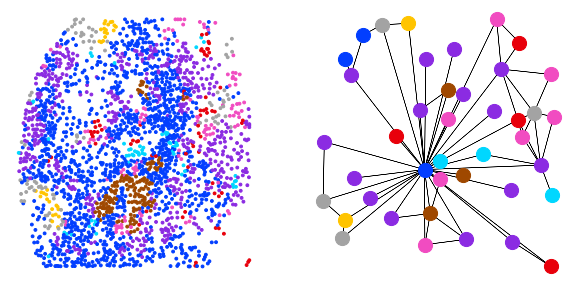

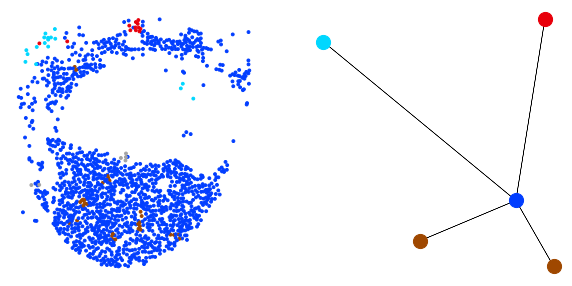

In [11]:
# visualizing a tissue graph

for spot_id in ['23_B', '19_A']:
    spot, spot_cn_cell_idxs, inst_assignments, kgr = spot_data[spot_id]

    figsize(10,5)


    plt.subplot(1,2,1)
    plt.scatter(spot['X:X'],spot['Y:Y'], c = [pal[cn] for cn in spot['neighborhood10']],s  = 8)
    plt.axis('off');

    plt.subplot(1,2,2)
    pos = {}
    draw = spot_adj_graphs[spot_id]

    for n in draw.nodes():
        cn = n[1]
        cn_cells, cn_assignments = inst_assignments[cn]
        sub_spot = spot.iloc[cn_cells[cn_assignments == n[2]]]
        pos[n] = np.mean(sub_spot['X:X']),np.mean(sub_spot['Y:Y'])
        plt.scatter(pos[n][0],pos[n][1], c = [pal[n[1]]], s =200)

    for s,t in draw.edges():
        x = pos[s][0]
        y = pos[s][1]
        dx = (pos[t][0]-x)
        dy = (pos[t][1]-y)


        alpha = 1
        col = 'black'

        plt.arrow(x,y,dx,dy,head_length =0, head_width = 0,length_includes_head= True,alpha = alpha,lw = 0.5,color = col,zorder = -1)

    plt.axis('off');
    plt.show()

## fragmentation

In [12]:
from scipy.stats import mannwhitneyu

In [13]:
spot_counts = {}
for a,v in spot_adj_graphs.items():
    spot_counts[a] = {'edge': np.mean([v.degree(n) for n in v.nodes()]), 'node': len(v.nodes)}

Text(0.5, 6.800000000000029, '')

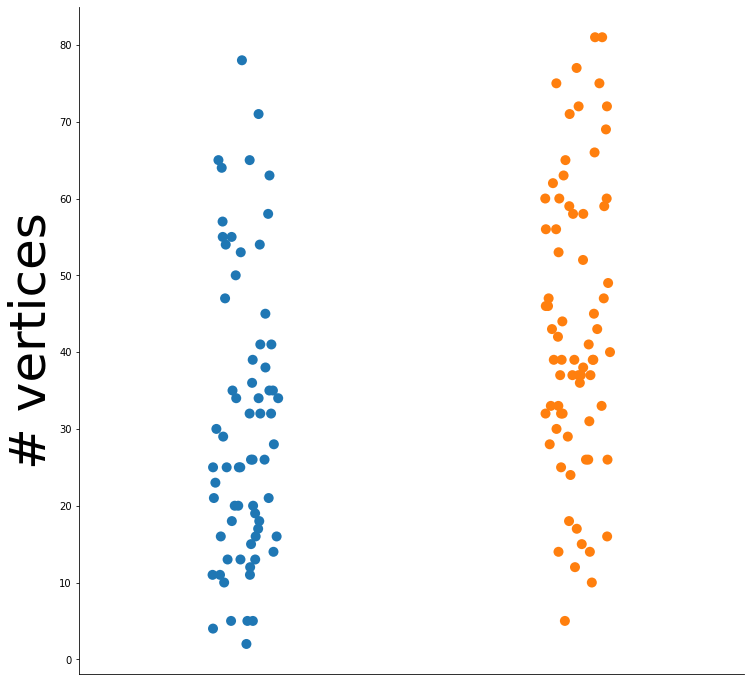

In [14]:

sns.catplot(data = pd.concat([pd.DataFrame({'gp':spot_group_assignment}),pd.DataFrame(spot_counts).T], axis = 1),
            x = 'gp',
            y = 'node',height = 10, s = 10)

plt.xticks([])
plt.ylabel('# vertices',fontsize = 50)
plt.xlabel('')

Text(0.5, 6.800000000000029, '')

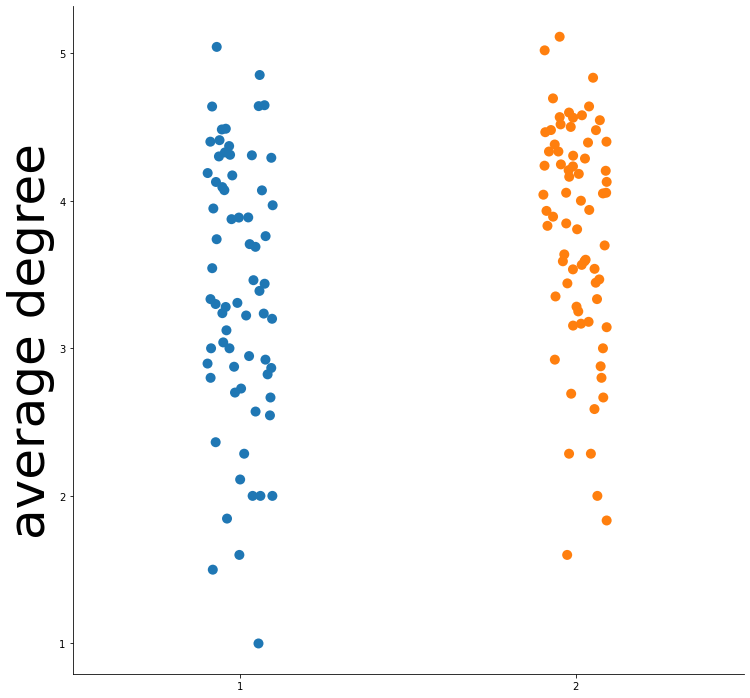

In [15]:

sns.catplot(data = pd.concat([pd.DataFrame({'gp':spot_group_assignment}),pd.DataFrame(spot_counts).T], axis = 1),
            x = 'gp',
            y = 'edge',height = 10, s = 10)
plt.ylabel('average degree',fontsize = 50)
plt.xlabel('')

### Group TMA cores to compute p values

In [16]:
dd = pd.concat([pd.DataFrame({'gp':spot_group_assignment}),pd.DataFrame({'pat':spot_to_patient}),pd.DataFrame(spot_counts).T], axis = 1)
dd = dd.groupby(['gp','pat'])[['edge','node']].mean().reset_index()
print(mannwhitneyu(dd['node'][dd['gp']==1],dd['node'][dd['gp']==2]))
print(mannwhitneyu(dd['edge'][dd['gp']==1],dd['edge'][dd['gp']==2]))

MannwhitneyuResult(statistic=63.0, pvalue=0.0031374482566353763)
MannwhitneyuResult(statistic=85.0, pvalue=0.025891721975398508)


# Extension frequencies

## Finding the rules in CLR/DII

In [17]:
adj_graphs = {}
adj_graph = nx.Graph()
for k,v in spot_adj_graphs.items():
    for s,t in v.edges():
        adj_graphs.setdefault(spot_group_assignment[k],nx.Graph()).add_edge(s,t)
        adj_graph.add_edge(s,t)

In [18]:
#start by defining a statistic over a graph, e.g.

def total_edgetype_counts(graph):
    counts = {}
    for s,t in graph.edges():
        key = tuple(sorted([s[1],t[1]]))
        counts.setdefault(key,0)
        counts[key] +=1
    return counts


#build a partition into isomorphism up to a certain level of structure
nodes_by_isom = {}
nodes_by_isom[1] = {}
nodes_by_isom[2] = {}

for v in adj_graph.nodes():
    spot, cn, _ = v
    
    # try that any instance can be mapped to any instance *within the same spot*
    isom = spot
    
    #edges_class = tuple(sorted(set([edge[1][1] for edge in adj_graph.edges(v)])))
    nodes_by_isom[spot_group_assignment[spot]].setdefault(isom,set()).add(v)
    


In [19]:
ty_nodes = {}
ty_edges = {}
for n in adj_graph.nodes():
    pat = spot_to_patient[n[0]]
    cn = n[1]
    ty_nodes.setdefault(pat,{}).setdefault(cn,set()).add(n)
    for _,e1 in adj_graph.edges(n):
        cn1 = e1[1]
        pair = tuple(sorted([cn,cn1]))
        ty_edges.setdefault(pat,{}).setdefault((cn,pair),set()).add(n)
       

In [20]:
all_edge_types = set()
for e in ty_edges.keys():
    all_edge_types = all_edge_types.union(ty_edges[e].keys())
    
all_node_types = set()
for e in ty_nodes.keys():
    all_node_types = all_node_types.union(ty_nodes[e].keys())

In [21]:
# observed distribution
count_base = {}
count_edges = {}
lift_freq = {}

for node_type in all_node_types:
    for pat,gp in pat_to_gp.items():
        to_add = len(ty_nodes[pat].setdefault(node_type,set()))
        cb = count_base.setdefault((gp,node_type), 0)
        cb = cb + to_add
        count_base[(gp,node_type)] = cb


for edge_type in all_edge_types:
    for pat,gp in pat_to_gp.items():
        to_add = len(ty_edges[pat].setdefault(edge_type,set()))
        ce = count_edges.setdefault((gp,edge_type), 0)
        ce = ce + to_add
        count_edges[(gp,edge_type)] = ce

    freq = count_edges[(1,edge_type)]/(1+count_base[(1, edge_type[0])])
    if freq > 1:
        print(edge_type)
        print(count_edges[(1,edge_type)])
        print(edge_type[0],count_base[(1,edge_type[0])])
        print('aaa')
    lift_freq['act',edge_type, 1] = count_edges[(1,edge_type)]/(1+count_base[(1, edge_type[0])])
    lift_freq['act',edge_type, 2] = count_edges[(2,edge_type)]/(1+count_base[(2, edge_type[0])])

In [22]:
obs_lfs = pd.DataFrame({'gp1':{j: lift_freq['act',j,1] for j in all_edge_types }, 'gp2': {j: lift_freq['act',j,2] for j in all_edge_types}})

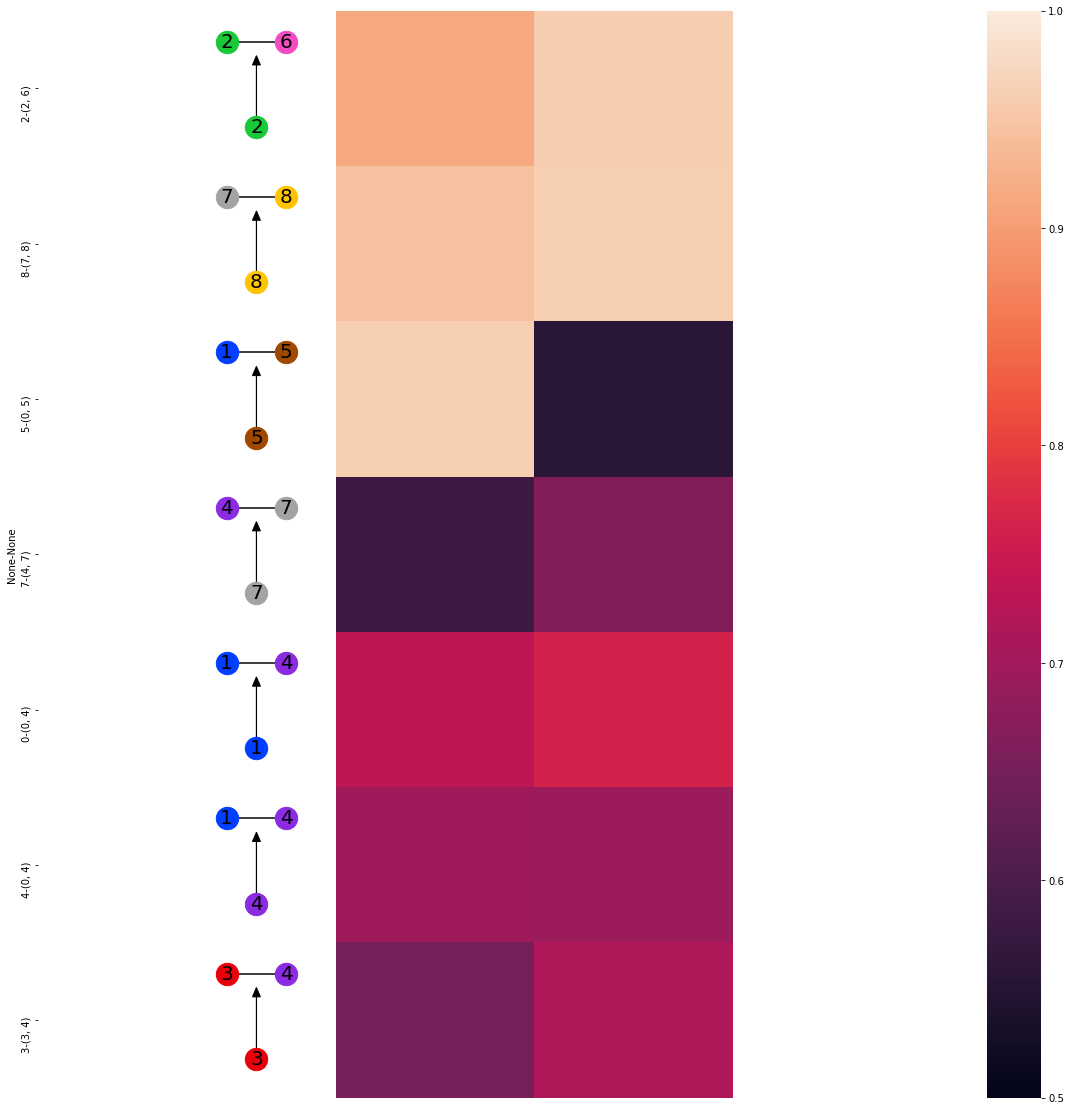

In [23]:
figsize(20,20)
oo = obs_lfs
oo['not1'] = [1 not in a[1] for a in oo.index.values ]
q = ((oo['gp2']>.65)|(oo['gp1']>.65)) & (oo['not1']) 
g =sns.clustermap(oo[q].iloc[:,:2], figsize = (1,1));
plt.close()

sns.heatmap(oo[q].iloc[g.dendrogram_row.reordered_ind,:-1], vmin = 0.5,vmax = 1) 
j = 0
for s, t in oo[q].iloc[g.dendrogram_row.reordered_ind,:-1].index.values:
    j+=1
    
    plt.scatter(-0.4,0.75 + (j-1), c = [pal[s]], s = 500)
    plt.text(-0.4,0.75 + (j-1),cn_names[s], ha = 'center', va = 'center',fontsize = 20)
    plt.scatter(-0.55,0.2 + (j-1),c = [pal[t[0]]], s = 500)
    plt.text(-0.55,0.2 + (j-1),cn_names[t[0]], ha = 'center', va = 'center',fontsize = 20)
    plt.scatter(-0.25,0.2 + (j-1),c = [pal[t[1]]], s = 500)
    plt.text(-0.25,0.2 + (j-1),cn_names[t[1]], ha = 'center', va = 'center',fontsize = 20)
    plt.arrow(-0.4,0.75+j-1, 0, -0.4,  head_width= 0.04, color = 'black',zorder = -2)
    plt.plot([-0.55,-0.25], [0.2 + (j-1),0.2 + (j-1)],zorder = -1, color = 'black')

plt.xticks([])
plt.xlim(-1.5,3)
plt.show()

## Differences in extension frequencies via permuting group assignments

In [63]:
# permutation distribution of extension frequencies
for gp_perm in tqdm(range(10000)):
    pat_to_gp_samp = {a:b for a,b, in zip(pat_gp['patients'].values,pat_gp['groups'].sample(frac = 1,random_state = gp_perm).values)}
    
    

    count_base = {} 
    for node_type in all_node_types:
        for pat,gp in pat_to_gp_samp.items():
            to_add = len(ty_nodes[pat].setdefault(node_type,set()))
            cb = count_base.setdefault((gp,node_type), 0)
            cb = cb + to_add
            count_base[(gp,node_type)] = cb
            
    count_edges = {}

    for edge_type in all_edge_types:
        for pat,gp in pat_to_gp_samp.items():
            to_add = len(ty_edges[pat].setdefault(edge_type,set()))
            ce = count_edges.setdefault((gp,edge_type), 0)
            ce = ce + to_add
            count_edges[(gp,edge_type)] = ce
            
            
        lift_freq[gp_perm,edge_type, 1] = count_edges[(1,edge_type)]/(1+count_base[(1, edge_type[0])])
        lift_freq[gp_perm,edge_type, 2] = count_edges[(2,edge_type)]/(1+count_base[(2, edge_type[0])])
         


In [64]:
# bonferroni corrected permutation p-values
perm_dist = pd.DataFrame({i:{j:lift_freq[i,j,1]- lift_freq[i,j,2] for j in all_edge_types} for i in range(10000)})
obs = pd.DataFrame({'obs':{j: lift_freq['act',j,1] -  lift_freq['act',j,2] for j in all_edge_types }})
pvals = np.minimum(1.0,90*(1 - np.mean((obs.values>0)*(obs.values> perm_dist.values) + (obs.values<0)*(obs.values< perm_dist.values),axis = 1)))

In [65]:
sig_lfs =  obs_lfs.loc[obs[pvals< 0.05].index.values]

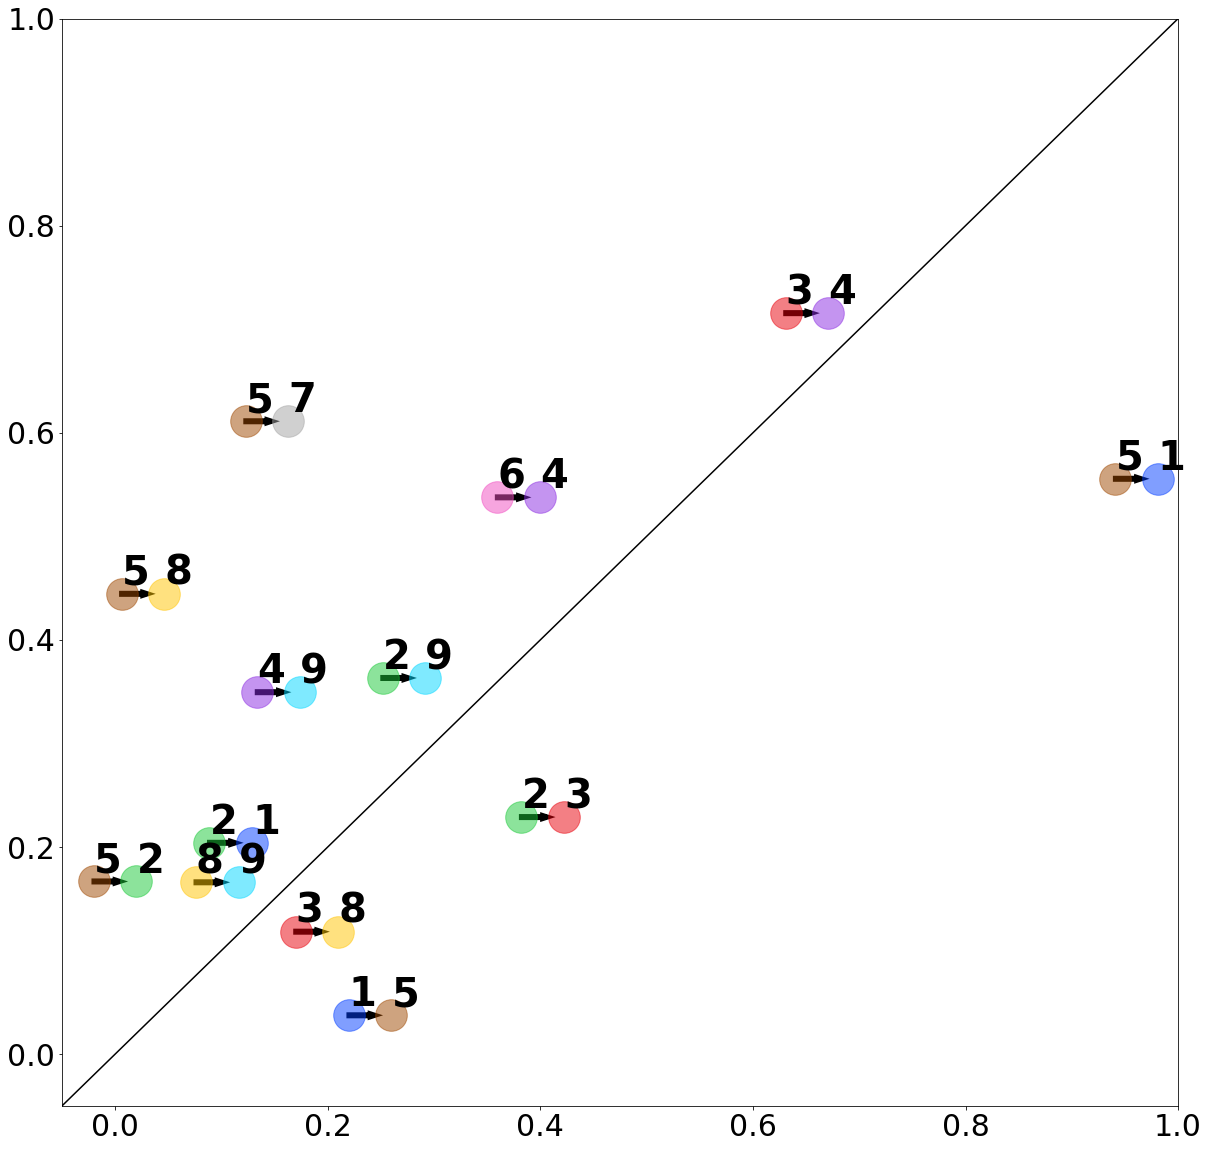

In [66]:
figsize(20,20)
pal = sns.color_palette('bright',10)
for k in sig_lfs.index.values:
    if 1 in k[1]:
        continue
    x = sig_lfs['gp1'].loc[k]
    y = sig_lfs['gp2'].loc[k]
    plt.scatter(x-0.02,y, c= [pal[k[0]]], s = 1000,alpha = 0.5)
    plt.text(x-0.02,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
    new = list(set(list(k[1]))-set([k[0]]))[0]
    plt.scatter(x+0.02,y, c= [pal[new]], s= 1000,alpha = 0.5)
    plt.arrow(x-0.02,y,0.02,0,zorder = -10,lw = 5)
    plt.text(x+0.02,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
plt.ylim(-0.05,1)
plt.xlim(-0.05,1)
plt.xticks(fontsize = 30);
plt.yticks(fontsize = 30);
plt.plot([-0.5,1],[-0.5,1],c = 'black')

plt.show()


# Motifs deviant from max. ent. null

## 2-chains

In [67]:
# generate a random map respecting the structure as defined by the partition
np.random.seed(23)

null_dist = []
for i in tqdm(range(10000)):
    permutation = {}
    for isom,equiv_class in nodes_by_isom[1].items():
        block0 = list(equiv_class)
        block1 = block0.copy()
        np.random.shuffle(block1)
        permutation.update({a:b for a,b in zip(block0,block1)})

    # now get a new graph (group 1 for now) 
    perm_graph = nx.Graph()
    for s,t in adj_graphs[1].edges():
        perm_graph.add_edge(permutation[s], permutation[t])

    # compute the statistic
    null_dist.append(pd.DataFrame({i:total_edgetype_counts(perm_graph)}))
edge_null_dist = pd.concat(null_dist,axis = 1).fillna(0)

# now we see which ones are significant after bonferroni
edge_observed = pd.DataFrame({'obs':total_edgetype_counts(adj_graphs[1])})
edge_null_distfill = edge_null_dist.fillna(0) # fillna 0 is OK because it's just the missing ones from each spot
corrected_pvalues = {}
for pair in edge_observed.index.values:
    s1 = 1-np.mean(edge_null_distfill.loc[pair].values < edge_observed.loc[pair]['obs'])
    s2 = 1-np.mean(edge_null_distfill.loc[pair].values > edge_observed.loc[pair]['obs'])
    # leave correction until later
    corrected_pvalues[pair] = min(s1,s2)#min(1,2*len(edge_observed.index.values) * min(s1,s2))

corrected = pd.DataFrame({'p':corrected_pvalues})
good1 = edge_observed.loc[edge_observed['obs'] >5]
meds1 = np.median(np.log2(good1.values/(1+edge_null_distfill.loc[good1.index.values].values)),axis = 1)
pv1 = corrected.loc[good1.index.values]

In [68]:
# generate a random map respecting the structure as defined by the partition
np.random.seed(23)

null_dist = []
for i in tqdm(range(10000)):
    permutation = {}
    for isom,equiv_class in nodes_by_isom[2].items():
        block0 = list(equiv_class)
        block1 = block0.copy()
        np.random.shuffle(block1)
        permutation.update({a:b for a,b in zip(block0,block1)})

    # now get a new graph (group 2 for now) 
    perm_graph = nx.Graph()
    for s,t in adj_graphs[2].edges():
        perm_graph.add_edge(permutation[s], permutation[t])

    # compute the statistic
    null_dist.append(pd.DataFrame({i:total_edgetype_counts(perm_graph)}))
edge_null_dist = pd.concat(null_dist,axis = 1).fillna(0)

# now we see which ones are significant after bonferroni
edge_observed = pd.DataFrame({'obs':total_edgetype_counts(adj_graphs[2])})
edge_null_distfill = edge_null_dist.fillna(0) # fillna 0 is OK because it's just the missing ones from each spot
corrected_pvalues = {}
for pair in edge_observed.index.values:
    s1 = 1-np.mean(edge_null_distfill.loc[pair].values < edge_observed.loc[pair]['obs'])
    s2 = 1-np.mean(edge_null_distfill.loc[pair].values > edge_observed.loc[pair]['obs'])
    # leave correction until later
    corrected_pvalues[pair] = min(s1,s2)#min(1,2*len(edge_observed.index.values) * min(s1,s2))

corrected = pd.DataFrame({'p':corrected_pvalues})
good2 = edge_observed.loc[edge_observed['obs'] >5]
meds2 = np.median(np.log2(good2.values/(1+edge_null_distfill.loc[good2.index.values].values)),axis = 1)
pv2 = corrected.loc[good2.index.values]

In [69]:
pv1_2ch = pv1.copy()
meds1_1ch = meds1.copy()
pv2_2ch = pv2.copy()
meds2_2ch = meds2.copy()

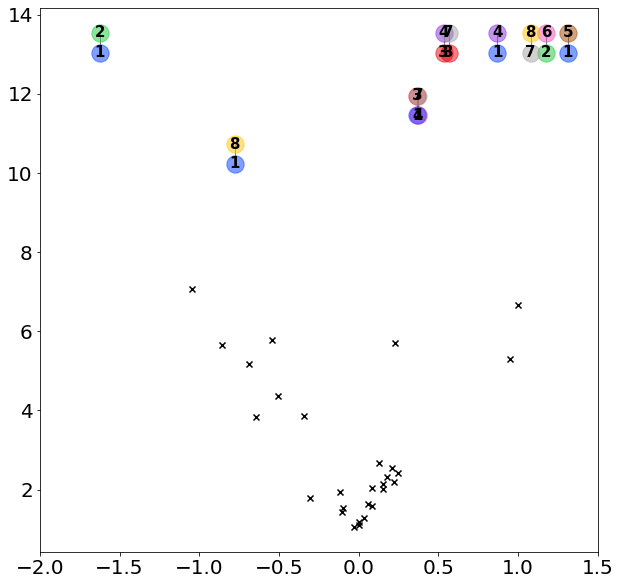

In [70]:
figsize(10,10)
for j,name in enumerate(pv1_2ch.index.values):
    z = 0
    u = meds1_1ch[j]
    v = -np.log2(1e-4+pv1_2ch.values[j])
   
    if pv1_2ch.values[j]<0.05/len(pv1_2ch):
        a,b = name
        plt.scatter(u,v-0.25, c=  [pal[a]],s = 300,alpha = 0.5)
        plt.scatter(u,v+0.25, c=  [pal[b]], s = 300,alpha = 0.5)
        plt.text(u,v-0.25, cn_names[a], ha = 'center', va = 'center',fontsize = 15, weight = 'bold')
        plt.text(u,v+0.25, cn_names[b], ha = 'center', va = 'center', fontsize = 15, weight = 'bold')
        plt.plot([u,u],[v-0.25,v+0.25], c = 'black',lw = .5,zorder = -10)
    else:
        plt.scatter(u,v, c = ['black'],marker = 'x')
        

plt.xlim(-2,1.5)

plt.xticks(fontsize = 20);
plt.yticks(fontsize = 20);

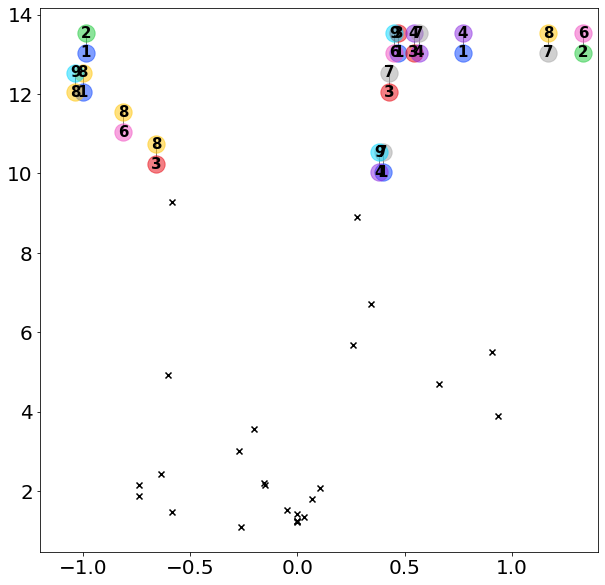

In [71]:
figsize(10,10)
for j,name in enumerate(pv2_2ch.index.values):
    z = 0
    u = meds2_2ch[j]
    v = -np.log2(1e-4+pv2_2ch.values[j])
   
    if pv2_2ch.values[j]<0.05/len(pv2):
        a,b = name
        plt.scatter(u,v-0.25, c=  [pal[a]],s = 300,alpha = 0.5)
        plt.scatter(u,v+0.25, c=  [pal[b]], s = 300,alpha = 0.5)
        plt.text(u,v-0.25, cn_names[a], ha = 'center', va = 'center',fontsize = 15, weight = 'bold')
        plt.text(u,v+0.25, cn_names[b], ha = 'center', va = 'center', fontsize = 15, weight = 'bold')
        plt.plot([u,u],[v-0.25,v+0.25], c = 'black',lw = .5,zorder = -10)
    else:
        plt.scatter(u,v, c = ['black'],marker = 'x')
        

plt.xlim(-1.2,1.4);

plt.xticks(fontsize = 20);
plt.yticks(fontsize = 20);

##  Triangles with MCMC

- This analysis can be found in a separate MCMC notebook

# Analysis of (0,4,7)

### Compute tissue graph

In [24]:
'''
this code takes a motif and finds all the extensions, keeping track of which instances can be extended
the input info it needs includes graphs and dicts that it updates
g: tissue graph
tc: motif
tc_to_c : dict motifs -> instances
L_graph : graph of motif extensions
L_to_c : dict edges of L_graph -> instances of source of edge that extend 
tc_to_e : dict motifs -> experiments they're found it

a motif (typically referred to as tc in the code) is stored as a tuple (A,B,C) where:
A is a sorted tuple of sorted pairs of CNs representing the adjacencies in the motif
B is a sorted tuple of CNs representing the CNs in the motif
C is a sorted tuple of sorted pairs of CN representing the 'NOT' adjacencies
'''

def extend_motif(g,tc,tc_to_c, L_to_c, L_graph,tc_to_e):
    ty_edges, ty_nodes = tc
    samp = tc_to_c[tc]
    if len(samp) >5000:
        samp = list(samp)
        idd = np.arange(len(samp))
        np.random.shuffle(idd)
        samp = [samp[i] for i in idd[:5000]]
        
    for tm in samp:
        for tm_node in tm:
            for e0,e1 in g.edges(tm_node):
                e = e0
                if e ==tm_node:
                    e = e1
                exp, new_ty, new_inst = e
                
                new_edge = tuple(sorted([e0[1],e1[1]]))
                if  new_edge in ty_edges:
                    continue
                
                
                
                ty_node_set = set(ty_nodes)
                
                if new_ty in ty_node_set:
                    kv = {i:j for i,j in zip(ty_nodes,tm)}
                    if kv[new_ty]!=e:
                        continue
                        
                        
                    
                
                
                
                ty_node_set.add(new_ty)
                new_ty_nodes = tuple(sorted(ty_node_set))
                idx = {tt:nod for tt,nod in zip(ty_nodes,tm)}
                idx[new_ty] = e
                new_tm = tuple([idx[j] for j in new_ty_nodes])
                
                
                
                
                ty_edge_set = set(ty_edges)
                ty_edge_set.add(new_edge)
                
#                 for f0, f1 in g.edges(e):
#                     if (f0 in new_tm) and (f1 in new_tm):
#                         ty_edge_set.add(tuple(sorted((f0[1],f1[1]))))
                
                new_ty_edges = tuple(sorted(ty_edge_set))
                
                new_tc = (new_ty_edges,new_ty_nodes)
                tc_to_c.setdefault(new_tc,set()).add(new_tm)
                
                L_to_c.setdefault((tc,new_tc), set()).add(tm)
                tc_to_e.setdefault(new_tc,set()).add(tm[0][0])
                L_graph.add_edge(tc,new_tc)
                    
                
                
        
'''
this function takes a graph and uses extend motifs above to find all the motifs, their instances, 
as well as which motifs extend
'''
def build_motifs(g):
    tc_to_c = {}
    tc_to_e = {}

    for e0,e1 in g.edges():
        exp0,cn0,i0 = e0
        exp1,cn1,i1 = e1
        tc = ((tuple(sorted([cn0,cn1])),), tuple(sorted([cn0,cn1])))
        tm = tuple(sorted([e0,e1], key = lambda x: x[1]))
        tc_to_c.setdefault(tc, set()).add(tm)
        tc_to_e.setdefault(tc, set()).add(exp0)

    #take conserved motifs built from chains and adding
    L_to_c = {}
    L_graph = nx.DiGraph()
    for tc in tc_to_c:
        L_graph.add_node(tc)


    #expand them with add node motif    
    for i in range(11):
        leaves = [t for t in L_graph.nodes() if L_graph.out_degree(t)==0 and (len(t[1])<=5)]
        for tc in leaves:
            extend_motif(g,tc,tc_to_c, L_to_c, L_graph,tc_to_e)
    return tc_to_c,L_to_c, L_graph

In [25]:
p = Pool(64)
motifs5 = list(tqdm(p.imap(build_motifs,[spot_adj_graphs[spot] for spot in spot_ids]), total = len(spot_ids)))

In [26]:
motifs = {k:v for k,v in zip(spot_ids,motifs5)}

In [27]:
tc_to_cs = {1:{},2:{}}
L_to_cs = {1:{},2:{}}
L_graphs = {1:nx.DiGraph(), 2:nx.DiGraph()}

In [28]:
for spot in spot_ids:
    tc_to_c, L_to_c, L_graph = motifs[spot]
    for k,v in tc_to_c.items():
        d = tc_to_cs[spot_group_assignment[spot]].setdefault(k, set())
        d = d.union(v)
        tc_to_cs[spot_group_assignment[spot]][k] = d
        
    for k,v in L_to_c.items():
        d = L_to_cs[spot_group_assignment[spot]].setdefault(k, set())
        d = d.union(v)
        L_to_cs[spot_group_assignment[spot]][k] = d
    
    for e0,e1 in L_graph.edges():
        L_graphs[spot_group_assignment[spot]].add_edge(e0,e1)

In [29]:
tc_to_pat = {1:{},2:{}}
for gp in [1,2]:
    for k,tm_set in tc_to_cs[gp].items():
        tc_to_pat[gp][k] = set()
        for tm in tm_set:
            spot = tm[0][0]
            tc_to_pat[gp][k].add(spot_to_patient[spot])



In [30]:
def draw_type(ty,seed =0):
    np.random.seed(seed)
    pal = sns.color_palette('bright',10)
    g = nx.Graph()
    for e in ty[0]:
        g.add_edge(e[0],e[1])
    print(g.nodes())
    
    nx.draw_networkx(g,node_color = [pal[n] for n in g.nodes()])

## Compute enrichment of extensions of (0,4,7)

In [31]:
from scipy.stats import chi2_contingency

In [32]:
pal = sns.color_palette('bright',10)
t047 = (((0, 4), (0, 7), (4, 7)), (0, 4, 7))

In [33]:
lifters = [a for a in set(L_to_cs[1].keys()).union(L_to_cs[2].keys()) if (len(a[0][0]) ==3) and (a[0][1])==(0,4,7) and (1 not in a[1][1])]

In [34]:
enrichment = {}
gp1_counts = {}
gp2_counts = {}
gp1_counts_base = {}
chisq_p = {}
gp2_counts_base = {}
for e0,e1 in lifters:
    enrichment[e0,e1] = np.log2(len(tc_to_pat[2].setdefault(e1,set()))/18) - np.log2(len(tc_to_pat[1].setdefault(e1,set()))/17)
    gp1_counts[e0,e1] = len(tc_to_pat[1][e1])
    gp2_counts[e0,e1] = len(tc_to_pat[2][e1])
    gp1_counts_base[e0,e1]= len(tc_to_pat[1][e0])/17
    gp2_counts_base[e0,e1]= len(tc_to_pat[2][e0])/18
    
    chisq_p[e0,e1] = chi2_contingency([[len(tc_to_pat[1][e1]),len(tc_to_pat[2][e1])],[17-len(tc_to_pat[1][e1]),18-len(tc_to_pat[2][e1])]])[1]
    
    

In [35]:
E = pd.DataFrame({'e':enrichment,'chisq_p':chisq_p,'gp1':gp1_counts, 'gp2':gp2_counts,'gp1_base':gp1_counts_base, 'gp2_base':gp2_counts_base}).sort_values(by = 'e')


In [36]:
E

e  \
(((0, 4), (0, 7), (4, 7)), (0, 4, 7)) (((0, 4), (0, 7), (4, 7), (5, 7)), (0, 4, 5, 7)) -1.667425   
                                      (((0, 4), (0, 5), (0, 7), (4, 7)), (0, 4, 5, 7)) -1.497500   
                                      (((0, 4), (0, 7), (4, 5), (4, 7)), (0, 4, 5, 7)) -1.082462   
                                      (((0, 3), (0, 4), (0, 7), (4, 7)), (0, 3, 4, 7))  0.017074   
                                      (((0, 4), (0, 7), (3, 4), (4, 7)), (0, 3, 4, 7))  0.017074   
                                      (((0, 4), (0, 7), (4, 7), (7, 8)), (0, 4, 7, 8))  0.043069   
                                      (((0, 4), (0, 7), (4, 7), (6, 7)), (0, 4, 6, 7))  0.043069   
                                      (((0, 4), (0, 7), (0, 8), (4, 7)), (0, 4, 7, 8))  0.110183   
                                      (((0, 4), (0, 7), (3, 7), (4, 7)), (0, 3, 4, 7))  0.217098   
                                      (((0, 4), (0, 7), (4, 7), (4, 8)), (0, 4, 7, 8))  0.376969   
                                      (((0, 4), (0, 7), (4, 7), (7, 9)), (0, 4, 7, 9))  0.376969   
                                      (((0, 4), (0, 6), (0, 7), (4, 7)), (0, 4, 6, 7))  0.502500   
                                      (((0, 4), (0, 7), (4, 6), (4, 7)), (0, 4, 6, 7))  0.554968   
                                      (((0, 4), (0, 7), (2, 7), (4, 7)), (0, 2, 4, 7))  0.724893   
                                      (((0, 4), (0, 7), (2, 4), (4, 7)), (0, 2, 4, 7))  0.917538   
                                      (((0, 4), (0, 7), (0, 9), (4, 7)), (0, 4, 7, 9))  0.917538   
                                      (((0, 4), (0, 7), (4, 7), (4, 9)), (0, 4, 7, 9))  1.033015   
                                      (((0, 2), (0, 4), (0, 7), (4, 7)), (0, 2, 4, 7))  2.917538   

                                                                                         chisq_p  \
(((0, 4), (0, 7), (4, 7)), (0, 4, 7)) (((0, 4), (0, 7), (4, 7), (5, 7)), (0, 4, 5, 7))  0.553690   
                                      (((0, 4), (0, 5), (0, 7), (4, 7)), (0, 4, 5, 7))  0.116063   
                                      (((0, 4), (0, 7), (4, 5), (4, 7)), (0, 4, 5, 7))  0.599169   
                                      (((0, 3), (0, 4), (0, 7), (4, 7)), (0, 3, 4, 7))  1.000000   
                                      (((0, 4), (0, 7), (3, 4), (4, 7)), (0, 3, 4, 7))  1.000000   
                                      (((0, 4), (0, 7), (4, 7), (7, 8)), (0, 4, 7, 8))  1.000000   
                                      (((0, 4), (0, 7), (4, 7), (6, 7)), (0, 4, 6, 7))  1.000000   
                                      (((0, 4), (0, 7), (0, 8), (4, 7)), (0, 4, 7, 8))  1.000000   
                                      (((0, 4), (0, 7), (3, 7), (4, 7)), (0, 3, 4, 7))  0.599169   
                                      (((0, 4), (0, 7), (4, 7), (4, 8)), (0, 4, 7, 8))  0.620864   
                                      (((0, 4), (0, 7), (4, 7), (7, 9)), (0, 4, 7, 9))  0.620864   
                                      (((0, 4), (0, 6), (0, 7), (4, 7)), (0, 4, 6, 7))  0.406621   
                                      (((0, 4), (0, 7), (4, 6), (4, 7)), (0, 4, 6, 7))  0.233694   
                                      (((0, 4), (0, 7), (2, 7), (4, 7)), (0, 2, 4, 7))  0.539192   
                                      (((0, 4), (0, 7), (2, 4), (4, 7)), (0, 2, 4, 7))  0.343837   
                                      (((0, 4), (0, 7), (0, 9), (4, 7)), (0, 4, 7, 9))  0.062330   
                                      (((0, 4), (0, 7), (4, 7), (4, 9)), (0, 4, 7, 9))  0.063965   
                                      (((0, 2), (0, 4), (0, 7), (4, 7)), (0, 2, 4, 7))  0.026288   

                                                                                        gp1  \
(((0, 4), (0, 7), (4, 7)), (0, 4, 7)) (((0, 4), (0, 7), (4, 7), (5, 7)), (0, 4, 5, 7))    3   
                                      (((0, 4), (0, 5), (0, 7), (4, 7)), (0, 4, 5, 7))    8   
        

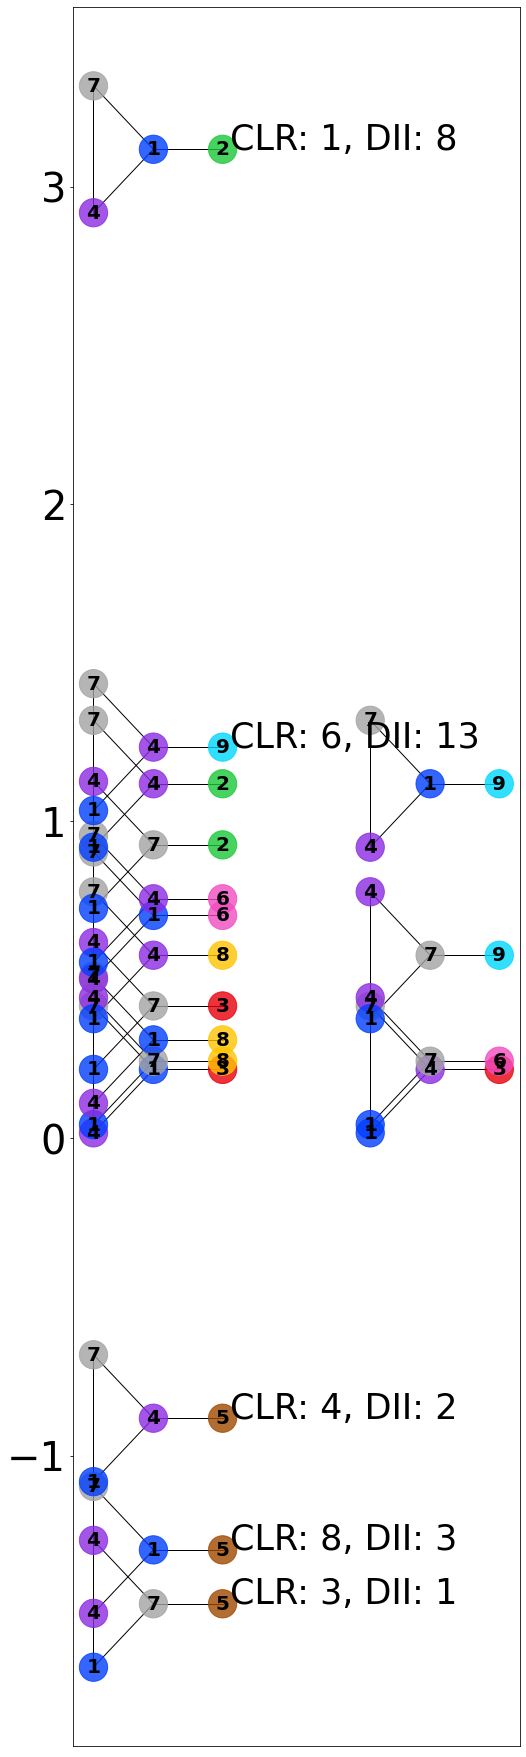

In [37]:
figsize(8,32)

offset = 12312
for i in range(E.shape[0]):
    s,t = E.index.values[i]
    
    scale = 0.4
    new_offset = E['e'].iloc[i]
    if new_offset ==offset:
        x_offset += 4*scale
    else:
        x_offset = 0
        
    offset= new_offset

    
    xs = x_offset+scale*np.array([0,0,np.cos(np.pi/6),1+np.cos(np.pi/6)])
    ys = offset + scale*np.array([0,1,np.sin(np.pi/6), np.sin(np.pi/6)])
    
    if abs(new_offset)>1:
        plt.text(xs[-1]+0.1*scale, ys[-1], 'CLR: {}, DII: {}'.format(E['gp1'].iloc[i],E['gp2'].iloc[i]),fontsize =35,zorder = 50)


    new_point = list(set(list(list(set(t[0]) - set(t047[0]))[0])) - set([0,4,7]))[0]
    right_point = list(set(list(list(set(t[0]) - set(t047[0]))[0])) - set([new_point]))[0]
    bottom_point,top_point = sorted(set([0,4,7]) - set([right_point]))

    lw = 1
    s = 2000*scale

    plt.scatter(xs,ys, c = [pal[j] for j in [bottom_point,top_point,right_point,new_point]],zorder = 10, s = s,alpha = 0.8)
    for x,y,p in zip(xs,ys, [bottom_point,top_point,right_point,new_point]):
        plt.text(x,y,cn_names[p],ha = 'center',va = 'center',zorder = 20,fontsize = 20,weight = 'bold')
        




    plt.plot([xs[0],xs[1]], [ys[0],ys[1]], c = 'black',lw = lw)
    plt.plot([xs[1],xs[2]], [ys[1],ys[2]], c = 'black',lw = lw)
    plt.plot([xs[0],xs[2]], [ys[0],ys[2]], c = 'black',lw = lw)
    plt.plot([xs[2],xs[3]], [ys[2],ys[3]], c = 'black',lw = lw,linestyle = '-')
    
plt.xticks([]);
plt.yticks(fontsize = 40);

## Assessing Survival wrt 047

In [38]:
from lifelines import KaplanMeierFitter,CoxPHFitter

In [39]:
tc = ((((0, 4), (0, 7), (4, 7)), (0, 4, 7)),
 (((0, 2), (0, 4), (0, 7), (4, 7)), (0, 2, 4, 7)))
bad_ty = tc[1]



In [50]:
surv = pd.read_excel('mendeley_surv.xlsx').set_index('Patient')
'''
mendeley_surv.xlsx is https://wiki.cancerimagingarchive.net/download/attachments/70227790/CRC_TMAs_patient_annotations.xlsx?version=1&modificationDate=1596640684172&api=v2
(the metadata from Schuerch et al. Cell 2020 uploaded to TCIA)
'''

gp2 = surv[surv['Group']==2]
gp2[str(tc)] = [pat in tc_to_pat[2][tc[1]] for pat in gp2.index.values]
cph = CoxPHFitter()
cph.fit(gp2.loc[:,['OS','OS_Censor',str(tc)]], 'OS',event_col = 'OS_Censor')
print(cph._compute_p_values())
cph.print_summary()

[0.00648641]


/media/raid/conda_2020/miniconda3/envs/graham/hier3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<lifelines.CoxPHFitter: fitted with 18 total observations, 5 right-censored observations>
             duration col = 'OS'
                event col = 'OS_Censor'
      baseline estimation = breslow
   number of observations = 18
number of events observed = 13
   partial log-likelihood = -26.67
         time fit was run = 2021-11-29 14:46:44 UTC

---
                                                                                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                                                         
((((0, 4), (0, 7), (4, 7)), (0, 4, 7)), (((0, 2), (0, 4), (0, 7), (4, 7)), (0, 2, 4, 7)))   1.78       5.94       0.65             0.50             3.06                 1.65                21.42

                                                                                             z    p   -log2(p)
covariate                                                                                                     
((((0, 4), (0, 7), (4, 7)), (0, 4, 7)), (((0, 2), (0, 4), (0, 7), (4, 7)), (0, 2, 4, 7))) 2.72 0.01       7.27
---
Concordance = 0.74
Partial AIC = 55.33
log-likelihood ratio test = 7.69 on 1 df
-log2(p) of ll-ratio test = 7.49

<AxesSubplot:xlabel='timeline'>

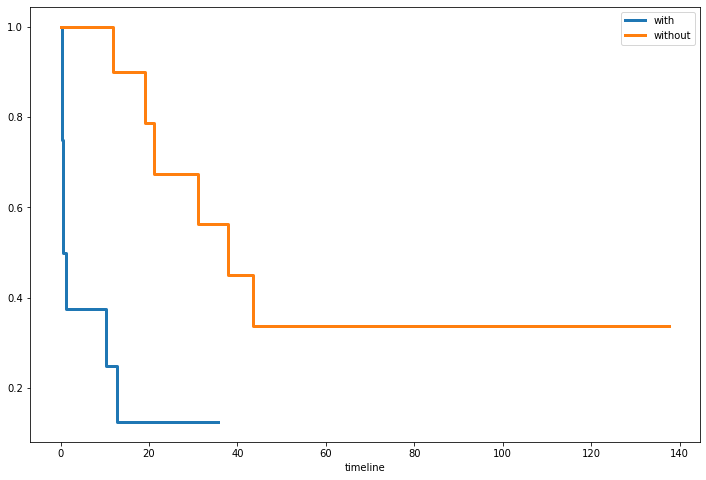

In [51]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
figsize(12,8)
dem = gp2[str(tc)]

kmf.fit(gp2['OS'][dem], event_observed=gp2['OS_Censor'][dem], label="with")
kmf.plot_survival_function(ci_show = False,lw = 3)

kmf.fit(gp2['OS'][~dem], event_observed=gp2['OS_Censor'][~dem], label="without")
kmf.plot_survival_function(ci_show = False,lw = 3)


## Survival/higher-order assembly graph

/media/raid/conda_2020/miniconda3/envs/graham/hier3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


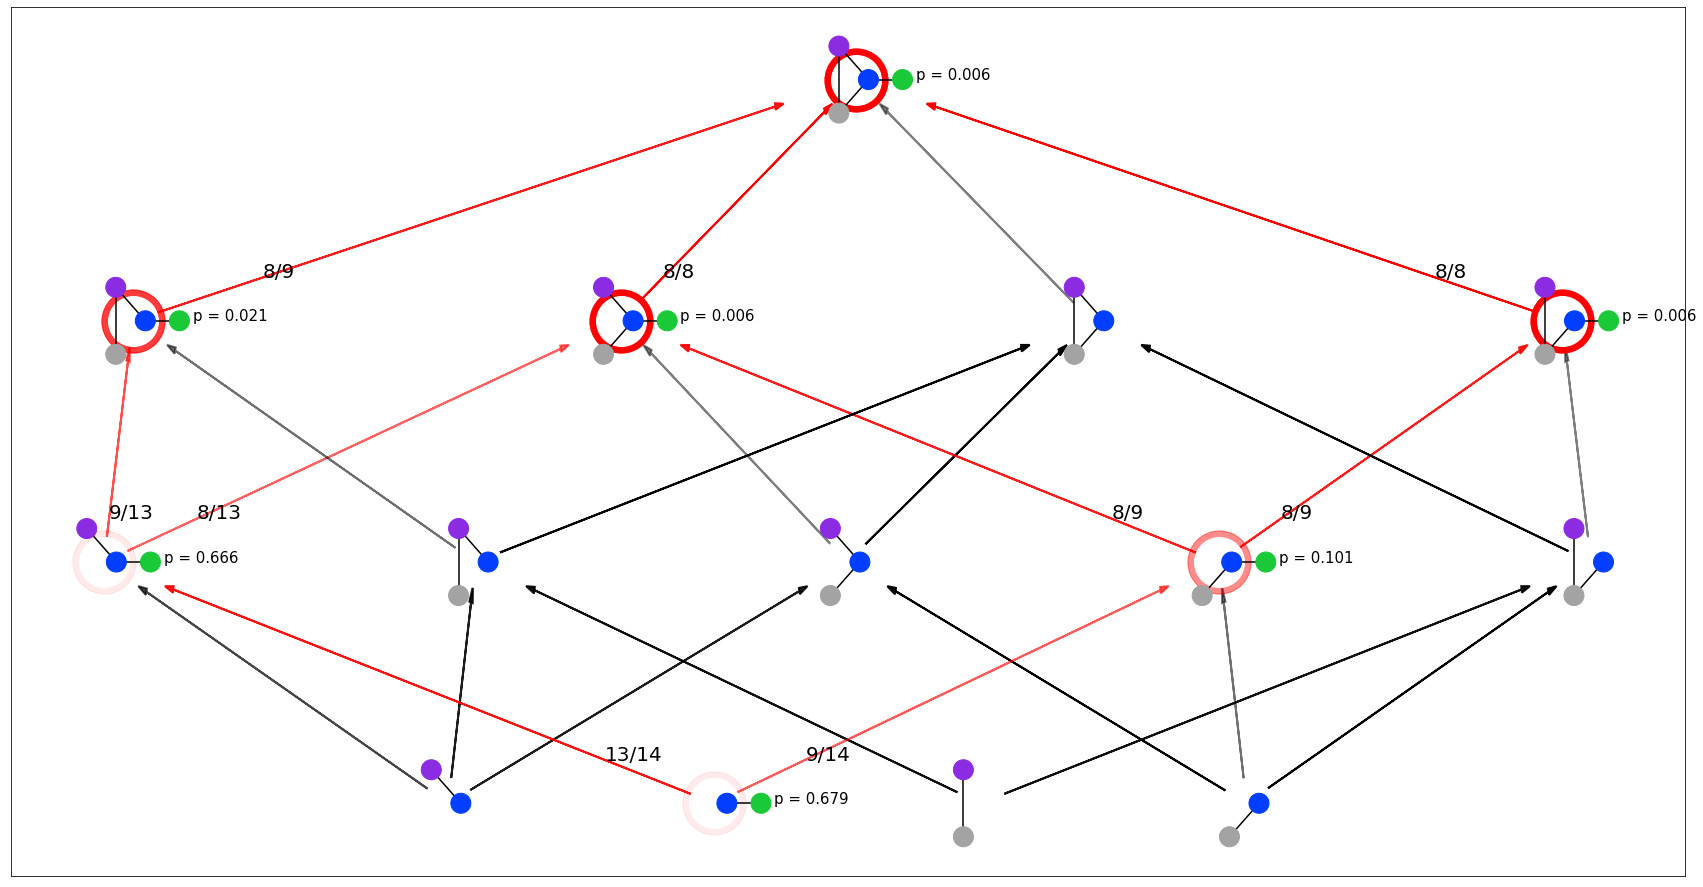

In [52]:
ancestors = nx.DiGraph(nx.subgraph(L_graphs[2],list(nx.ancestors(L_graphs[2],bad_ty))+[bad_ty]))
surv = pd.read_csv('crc_patient_surv.csv').set_index('Patient')
gp2 = surv[surv['Group']==2]
columns = set()
for tc in  ancestors.nodes():
    gp2[str(tc)] = [pat in tc_to_pat[2][tc] for pat in gp2.index.values]
    columns.add(tc)
    
cph = CoxPHFitter()
pvals = {}
for tc in tqdm(columns):
    if len(tc_to_pat[2][tc])<15:
        cph.fit(gp2.loc[:,['OS','OS_Censor',str(tc)]], 'OS',event_col = 'OS_Censor')
        pvals[tc] = cph._compute_p_values()[0]
    else:
        pvals[tc] = 1
pvs = pd.DataFrame({'pv':pvals}).sort_values(by = 'pv')

draw = ancestors
pos = nx.drawing.nx_pydot.graphviz_layout(draw, prog='dot')
pos = {k:(x,-y) for k,(x,y) in pos.items()}

figsize(30,16)
scale = 20

subpos = {0:2, 4:1,7:0, 2:3}
for n in draw.nodes():
    alpha = 1
    
    xs = pos[n][0]+scale*(np.array([0,0,np.cos(np.pi/6),1+np.cos(np.pi/6)]) - 0.5)
    ys = pos[n][1]+ scale*(np.array([0,1,np.sin(np.pi/6), np.sin(np.pi/6)]) - 0.5)
    
    plt.scatter([xs[subpos[j]] for j in n[1]],[ys[subpos[j]] for j in n[1]],c = [pal[j] for j in n[1]], s= 400,alpha = alpha,zorder = 50)
    
    plt.scatter(pos[n][0], pos[n][1], c = 'red', s =4000,alpha = -np.log10(pvals[n])/np.max(-np.log10(pvs)))
    plt.scatter(pos[n][0], pos[n][1], c = 'white', s =2500)
    
    if pvals[n] < 1:
        plt.text(pos[n][0]+35, pos[n][1], 'p = %.3f'%pvals[n], fontsize = 15)
    
    for s,t in n[0]:
        plt.plot([xs[subpos[s]], xs[subpos[t]]],[ys[subpos[s]], ys[subpos[t]]], c = 'black')
    


    
for s,t in draw.edges():
    x = pos[s][0]
    y = pos[s][1]
    dx = 0.9*(pos[t][0]-x)
    dy = 0.9*(pos[t][1]-y)
    
    
    alpha = len(tc_to_pat[2][t])/len(tc_to_pat[2][s])
    col = 'black'
    if pvals[s] < 0.7:
        plt.text(x+0.2*dx, y+0.2*dy, ('{}/{}'.format(len(tc_to_pat[2][t]),len(tc_to_pat[2][s]))),fontsize = 20)
        col = 'red'
    
    plt.arrow(x,y,dx,dy,head_length =5, head_width = 2,length_includes_head= True,alpha = alpha,lw = 2,color = col,zorder = -1)



plt.xticks([])
plt.yticks([])
plt.show()

## Comparing with the results of previous paper regarding PD-1 Cells

In [53]:
pd1_means = cells2.groupby(['neighborhood10','patients','groups'])['CD4+PD-1+'].mean().reset_index().dropna()

In [54]:
pd1_means.head()

,neighborhood10,patients,groups,CD4+PD-1+
0,0,1,1,0.001721
1,0,2,2,0.017413
2,0,3,2,0.000795
3,0,4,2,0.010463
4,0,5,2,0.065201


In [55]:
x = pd1_means[ (pd1_means['groups']==2) & (pd1_means['neighborhood10']==9)].set_index('patients')
x['has_bad_ty'] = False
x['has_bad_ty'].loc[tc_to_pat[2][bad_ty]] = True

/media/raid/conda_2020/miniconda3/envs/graham/hier3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [56]:
from scipy.stats import ranksums,ttest_ind

In [57]:
ranksums(x['CD4+PD-1+'].loc[x['has_bad_ty']],x['CD4+PD-1+'].loc[~x['has_bad_ty']])

RanksumsResult(statistic=-1.1106541457982981, pvalue=0.2667172467159161)

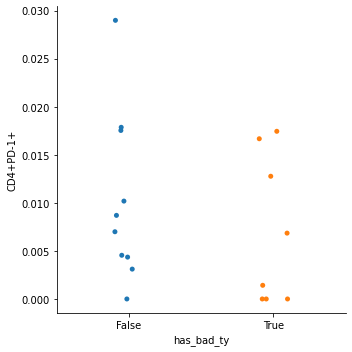

In [58]:
sns.catplot(data = x, x = 'has_bad_ty', y = 'CD4+PD-1+') 

In [59]:
surv = pd.read_csv('crc_patient_surv.csv').set_index('Patient')
gp2 = surv[surv['Group']==2]
gp2['pd1'] = np.log(1e-4+x['CD4+PD-1+'].loc[gp2.index.values])
gp2['bad'] = x['has_bad_ty'].loc[gp2.index.values]


cph = CoxPHFitter()
cph.fit(gp2.loc[:,['OS','OS_Censor','pd1','bad']], 'OS',event_col = 'OS_Censor')
        

/media/raid/conda_2020/miniconda3/envs/graham/hier3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/media/raid/conda_2020/miniconda3/envs/graham/hier3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<lifelines.CoxPHFitter: fitted with 18 total observations, 5 right-censored observations>

In [60]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 18 total observations, 5 right-censored observations>
             duration col = 'OS'
                event col = 'OS_Censor'
      baseline estimation = breslow
   number of observations = 18
number of events observed = 13
   partial log-likelihood = -21.99
         time fit was run = 2021-11-29 14:46:54 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
pd1        -0.55       0.58       0.19            -0.93            -0.18                 0.40                 0.84
bad         2.09       8.11       0.74             0.64             3.55                 1.89                34.72

              z      p   -log2(p)
covariate                        
pd1       -2.88 <0.005       7.98
bad        2.82 <0.005       7.70
---
Concordance = 0.86
Partial AIC = 47.98
log-likelihood ratio test = 17.04 on 2 df
-log2(p) of ll-ratio test = 12.29

## Finding chains exclusively in DII patients without bad one

[0, 3, 4, 7, 9, 8]
(((0, 3), (0, 4), (0, 7), (0, 9), (3, 7), (4, 8)), (0, 3, 4, 7, 8, 9))


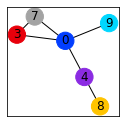

[0, 3, 7, 9, 4, 8]
(((0, 3), (0, 7), (0, 9), (3, 7), (4, 7), (4, 8)), (0, 3, 4, 7, 8, 9))


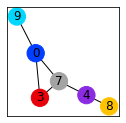

[0, 3, 9, 7, 4, 8]
(((0, 3), (0, 9), (3, 7), (4, 7), (4, 8)), (0, 3, 4, 7, 8, 9))


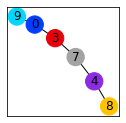

[0, 7, 3, 4, 9]
(((0, 7), (3, 4), (3, 9), (4, 9), (7, 9)), (0, 3, 4, 7, 9))


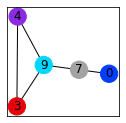

[0, 3, 4, 9, 7, 8]
(((0, 3), (0, 4), (0, 9), (3, 7), (4, 8), (7, 8)), (0, 3, 4, 7, 8, 9))


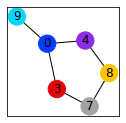

[0, 3, 9, 7, 4, 8]
(((0, 3), (0, 9), (3, 7), (4, 7), (4, 8), (7, 8)), (0, 3, 4, 7, 8, 9))


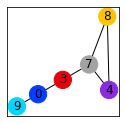

[0, 3, 6, 7, 4, 8]
(((0, 3), (0, 6), (3, 7), (4, 7), (4, 8), (7, 8)), (0, 3, 4, 6, 7, 8))


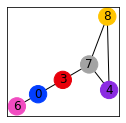

[0, 3, 9, 7, 4, 8]
(((0, 3), (0, 9), (3, 7), (4, 8), (7, 8)), (0, 3, 4, 7, 8, 9))


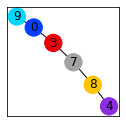

[0, 3, 6, 7, 4, 8]
(((0, 3), (0, 6), (3, 7), (4, 8), (7, 8)), (0, 3, 4, 6, 7, 8))


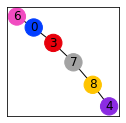

In [61]:
figsize(2,2)
orthogs = [a for a in tc_to_pat[2].keys() if (len(tc_to_pat[2][a]) > 4) and len(tc_to_pat[2][a].intersection (tc_to_pat[2][bad_ty]))==0 and (0 in a[1]) and (7 in a[1]) and (4 in a[1]) ]

for ty in sorted(orthogs, key = lambda x : -len(set(x[0]).intersection(set(bad_ty[0])))):
    draw_type(ty)
    print(ty)
    plt.show()


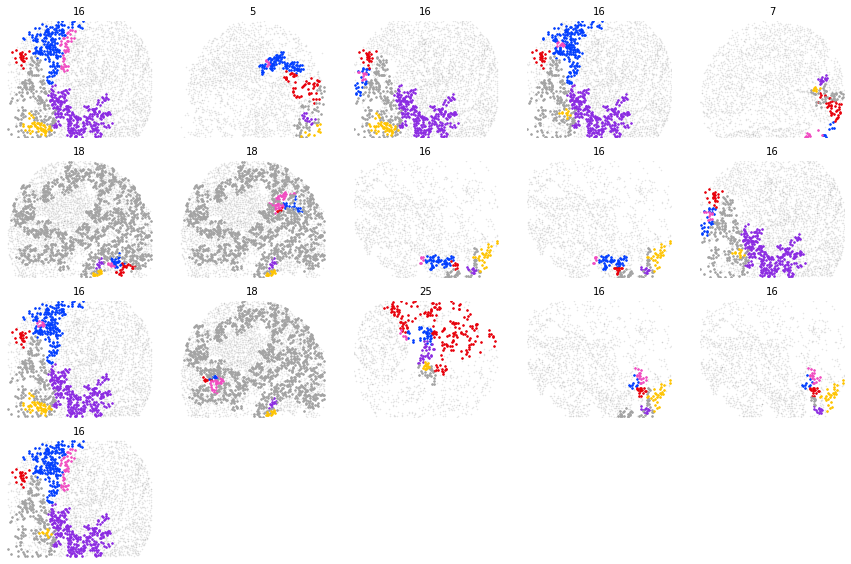

In [62]:
j = 0
figsize(15,15)
#ty = (((0, 3), (0, 4), (0, 7), (0, 9), (3, 7), (4, 8)), (0, 3, 4, 7, 8, 9))
#ty = (((0, 7), (3, 4), (3, 9), (4, 9), (7, 9)), (0, 3, 4, 7, 9))
ty = (((0, 3), (0, 6), (3, 7), (4, 7), (4, 8), (7, 8)), (0, 3, 4, 6, 7, 8))
for a in list(tc_to_cs[2][ty])[:30]:
    j+=1
    plt.subplot(6,5,j)
    spot_id = a[0][0]
    spot, spot_cn_cell_idxs, inst_assignments,kgr  = spot_data[spot_id]
    
    xmin = np.min(spot['X:X'])-5
    xmax = np.max(spot['X:X'])+5

    ymin = np.min(spot['Y:Y'])-5
    ymax = np.max(spot['Y:Y'])+5
    plt.scatter(spot['X:X'],spot['Y:Y'], c= ['black'], alpha = 0.08, s = 0.5)
    for tm in a:
        cn = tm[1]
        cn_cells, cn_assignments = inst_assignments[cn]
        sub_spot = spot.iloc[cn_cells[cn_assignments == tm[2]]]
        
        plt.scatter(sub_spot['X:X'],sub_spot['Y:Y'],c = [pal[cn]],alpha = 1,s = 2.5)
        
        plt.ylim(ymin,ymax)
        plt.xlim(xmin,xmax)
    plt.title(spot_to_patient[spot_id],fontsize = 10)
    plt.axis('off')
plt.show()
        